In [1]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.keras.applications.ResNet50V2(
          include_top=False, weights=None, input_shape=(128,128,3), pooling="avg"
      ).summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_conv[0][0]']    

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 5
CROP_TO = 32
SEED = 26



PROJECT_DIM = 2048
LATENT_DIM = 512
WEIGHT_DECAY = 0.0005


In [4]:
def flip_random_crop(image):
    # With random crops we also apply horizontal flipping.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    return image


def color_jitter(x, strength=[0.4, 0.4, 0.4, 0.1]):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength[0])
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength[1], upper=1 + 0.8 * strength[1]
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength[2], upper=1 + 0.8 * strength[2]
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength[3])
    # Affine transformations can disturb the natural range of
    # RGB images, hence this is needed.
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    # As discussed in the SimCLR paper, the series of augmentation
    # transformations (except for random crops) need to be applied
    # randomly to impose translational invariance.
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.8)
    image = random_apply(color_drop, image, p=0.2)
    return image


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
ssl_ds = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds = (
    ssl_ds.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)



In [6]:
dataset_supervised_train=(
    tf.data.Dataset.from_tensor_slices((x_train,y_train)).
shuffle(1024, seed=SEED)
    .map(lambda x,y : (custom_augment(x),y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)






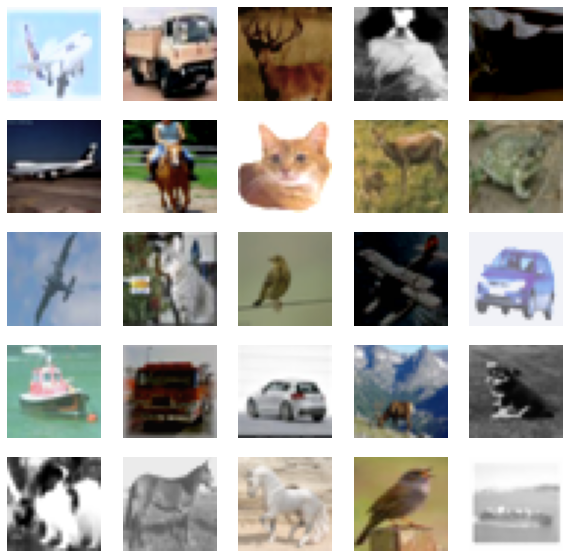

In [7]:




# We then zip both of these datasets.
ssl_ds_zip = tf.data.Dataset.zip((ssl_ds, ssl_ds))



# Ensure that the different versions of the dataset actually contain
# identical images.
sample_image = next(iter(ssl_ds_zip))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_image[n%2][n//2,:,:,:].numpy().astype("int"))
    plt.axis("off")
plt.show()



# definition projection head : 

# define the training procedure

- wich optimizer will be used
- how will the loss be computed (in the standard case, we compute the loss relative to the output of the model & the correct
- what function do we use for the loss

In [8]:
import resnet_cifar10_v2

N = 2
DEPTH = N * 9 + 2
NUM_BLOCKS = ((DEPTH - 2) // 9) - 1


def get_encoder(backbone=None):
    # Input and backbone.
    inputs = layers.Input((CROP_TO, CROP_TO, 3))
    
    
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(
        inputs
    )
    if backbone:
        x=backbone(x)
    else:
        x = resnet_cifar10_v2.stem(x)
        x = resnet_cifar10_v2.learner(x, NUM_BLOCKS)
    x = layers.GlobalAveragePooling2D(name="backbone_pool")(x)

    # Projection head.
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dense(
        PROJECT_DIM, use_bias=False, kernel_regularizer=regularizers.l2(WEIGHT_DECAY)
    )(x)
    outputs = layers.BatchNormalization()(x)
    return tf.keras.Model(inputs, outputs, name="encoder")




def get_predictor():
    model = tf.keras.Sequential(
        [
            # Note the AutoEncoder-like structure.
            layers.Input((PROJECT_DIM,)),
            layers.Dense(
                LATENT_DIM,
                use_bias=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
            ),
            layers.ReLU(),
            layers.BatchNormalization(),
            layers.Dense(PROJECT_DIM),
        ],
        name="predictor",
    )
    return model



def create_classifier(encoder, trainable=True):
    dropout_rate=0.5
    hidden_units = 512
    num_classes=10
    learning_rate=0.001
    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = tf.keras.Input(shape=(CROP_TO, CROP_TO, 3))
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## using compile & custum loss 

expect to compute the loss of the ouput of the neural network relative to the label of the datas. <br />
In order to implement this, we need to make a fake labels with the same length than the original dataset <br />

because the model includes l1 loss from the projection head, the loss is not between 0&1


In [9]:
def compute_loss(p, z):
    # The authors of SimSiam emphasize the impact of
    # the `stop_gradient` operator in the paper as it
    # has an important role in the overall optimization.
    z = tf.stop_gradient(z)
    p = tf.math.l2_normalize(p, axis=1)
    z = tf.math.l2_normalize(z, axis=1)
    # Negative cosine similarity (minimizing this is
    # equivalent to maximizing the similarity).
    return -tf.reduce_mean(tf.reduce_sum((p * z), axis=1))




    

In [10]:
def plot_history(history):
    plt.plot(history.history["loss_sim"])
    plt.grid()
    plt.title("Negative Cosine Similairty")
    plt.show()
    
    
    
def compile_and_train(similarity_network,show_history=True):
    num_training_samples = len(x_train)
    steps = EPOCHS * (num_training_samples // BATCH_SIZE)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.03, decay_steps=steps
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss_sim", patience=5, restore_best_weights=True
    )
    similarity_network.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
    history=similarity_network.fit(ssl_ds_zip, epochs=EPOCHS, callbacks=[early_stopping])
    if show_history:
        plot_history(history)

                
def test_network(simsiam,epochs=10):
    backbone= tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
    )

    classifier=create_classifier(backbone,trainable=False)

    history = classifier.fit(dataset_supervised_train, epochs=epochs)

    accuracy = classifier.evaluate(x_test, y_test)[1]
    
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")


## without the regularisation loss

Epoch 1/5
391/391 [==============================] - 131s 242ms/step - loss_sim: -0.8591 - loss_regu: 1.5922
Epoch 2/5
391/391 [==============================] - 92s 234ms/step - loss_sim: -0.9310 - loss_regu: 1.5921
Epoch 3/5
391/391 [==============================] - 92s 234ms/step - loss_sim: -0.9377 - loss_regu: 1.5921
Epoch 4/5
391/391 [==============================] - 92s 235ms/step - loss_sim: -0.9401 - loss_regu: 1.5921
Epoch 5/5
391/391 [==============================] - 92s 236ms/step - loss_sim: -0.9407 - loss_regu: 1.5921


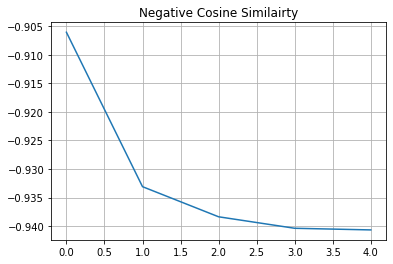

In [11]:

class SimSiam(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_similarity_tracker = tf.keras.metrics.Mean(name="loss_similarity")
        self.loss_regularization_tracker = tf.keras.metrics.Mean(name="loss_regularization")
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)
        return z1,p1,z2,p2

    @property
    def metrics(self):#in order to apply reset_state() automaticly
        return [self.loss_similarity_tracker,self.loss_regularization_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss_similarity = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
            loss_regularization=sum(self.losses)/2
            loss=loss_similarity

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_similarity_tracker.update_state(loss_similarity)
        self.loss_regularization_tracker.update_state(loss_regularization)
        return {"loss_sim": self.loss_similarity_tracker.result(),"loss_regu": self.loss_regularization_tracker.result()}

simsiam=SimSiam(get_encoder(),get_predictor())
compile_and_train(simsiam)


In [12]:
test_network(simsiam)

Epoch 1/10
391/391 [==============================] - 31s 45ms/step - loss: 3.6305 - sparse_categorical_accuracy: 0.2149
Epoch 2/10
391/391 [==============================] - 18s 46ms/step - loss: 3.5420 - sparse_categorical_accuracy: 0.2506
Epoch 3/10
391/391 [==============================] - 19s 47ms/step - loss: 3.5158 - sparse_categorical_accuracy: 0.2609
Epoch 4/10
391/391 [==============================] - 18s 47ms/step - loss: 3.5020 - sparse_categorical_accuracy: 0.2691
Epoch 5/10
391/391 [==============================] - 18s 46ms/step - loss: 3.4924 - sparse_categorical_accuracy: 0.2697
Epoch 6/10
391/391 [==============================] - 19s 48ms/step - loss: 3.4919 - sparse_categorical_accuracy: 0.2713
Epoch 7/10
391/391 [==============================] - 18s 45ms/step - loss: 3.4864 - sparse_categorical_accuracy: 0.2750
Epoch 8/10
391/391 [==============================] - 19s 48ms/step - loss: 3.4861 - sparse_categorical_accuracy: 0.2720
Epoch 9/10
391/391 [============

## with the regularisation loss

Epoch 1/5
391/391 [==============================] - 117s 243ms/step - loss_sim: -0.8462 - loss_regu: 1.5812
Epoch 2/5
391/391 [==============================] - 96s 244ms/step - loss_sim: -0.9108 - loss_regu: 1.5383
Epoch 3/5
391/391 [==============================] - 95s 243ms/step - loss_sim: -0.9167 - loss_regu: 1.5061
Epoch 4/5
391/391 [==============================] - 95s 242ms/step - loss_sim: -0.9191 - loss_regu: 1.4875
Epoch 5/5
391/391 [==============================] - 95s 241ms/step - loss_sim: -0.9203 - loss_regu: 1.4808


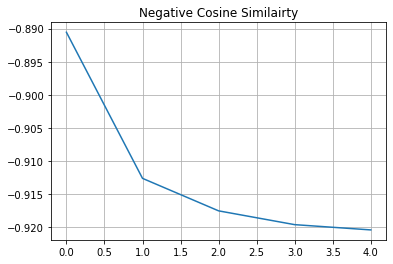

In [13]:

class SimSiam_with_regu(tf.keras.Model):
    def __init__(self, encoder, predictor):
        super(SimSiam_with_regu, self).__init__()
        self.encoder = encoder
        self.predictor = predictor
        self.loss_similarity_tracker = tf.keras.metrics.Mean(name="loss_similarity")
        self.loss_regularization_tracker = tf.keras.metrics.Mean(name="loss_regularization")
    def call(self, inputs):
        
        ds_one, ds_two = inputs[0],inputs[1]
        z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
        p1, p2 = self.predictor(z1), self.predictor(z2)
        return z1,p1,z2,p2

    @property
    def metrics(self):#in order to apply reset_state() automaticly
        return [self.loss_similarity_tracker,self.loss_regularization_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z1, z2 = self.encoder(ds_one), self.encoder(ds_two)
            p1, p2 = self.predictor(z1), self.predictor(z2)
            # Note that here we are enforcing the network to match
            # the representations of two differently augmented batches
            # of data.
            loss_similarity = compute_loss(p1, z2) / 2 + compute_loss(p2, z1) / 2
            loss_regularization=sum(self.losses)/2
            loss=loss_similarity+loss_regularization

        # Compute gradients and update the parameters.
        learnable_params = (
            self.encoder.trainable_variables + self.predictor.trainable_variables
        )
        gradients = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(gradients, learnable_params))

        # Monitor loss.
        self.loss_similarity_tracker.update_state(loss_similarity)
        self.loss_regularization_tracker.update_state(loss_regularization)
        return {"loss_sim": self.loss_similarity_tracker.result(),"loss_regu": self.loss_regularization_tracker.result()}
def plot_history(history):
    plt.plot(history.history["loss_sim"])
    plt.grid()
    plt.title("Negative Cosine Similairty")
    plt.show()
    
    
    
def compile_and_train(similarity_network,show_history=True):
    num_training_samples = len(x_train)
    steps = EPOCHS * (num_training_samples // BATCH_SIZE)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.03, decay_steps=steps
    )

    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="loss_sim", patience=5, restore_best_weights=True
    )
    similarity_network.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))
    history=similarity_network.fit(ssl_ds_zip, epochs=EPOCHS, callbacks=[early_stopping])
    if show_history:
        plot_history(history)


data=next(iter(ssl_ds_zip))
simsiam=SimSiam_with_regu(get_encoder(),get_predictor())
compile_and_train(simsiam)


In [14]:

test_network(simsiam)

Epoch 1/10
391/391 [==============================] - 30s 47ms/step - loss: 3.5938 - sparse_categorical_accuracy: 0.1880
Epoch 2/10
391/391 [==============================] - 18s 46ms/step - loss: 3.5179 - sparse_categorical_accuracy: 0.2199
Epoch 3/10
391/391 [==============================] - 18s 46ms/step - loss: 3.5019 - sparse_categorical_accuracy: 0.2274
Epoch 4/10
391/391 [==============================] - 144s 368ms/step - loss: 3.4898 - sparse_categorical_accuracy: 0.2322
Epoch 5/10
391/391 [==============================] - 17s 35ms/step - loss: 3.4778 - sparse_categorical_accuracy: 0.2358
Epoch 6/10
391/391 [==============================] - 16s 34ms/step - loss: 3.4681 - sparse_categorical_accuracy: 0.2384
Epoch 7/10
391/391 [==============================] - 18s 39ms/step - loss: 3.4644 - sparse_categorical_accuracy: 0.2419
Epoch 8/10
391/391 [==============================] - 24s 45ms/step - loss: 3.4627 - sparse_categorical_accuracy: 0.2465
Epoch 9/10
391/391 [==========

In [ ]:
test_network(simsiam,epochs=50)

# train the representation 

In [ ]:
simsiam.encoder.summary()

In [ ]:

lr=0.001

# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    simsiam.encoder.input, simsiam.encoder.get_layer("backbone_pool").output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = layers.Dense(10, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(lr, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=EPOCHS, 
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))


